In [1]:
from __future__ import print_function, division

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, Conv2D,UpSampling2D,LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop

import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np
import pandas as pd

from tensorflow.keras.datasets import mnist


In [2]:
class WGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
                            optimizer=optimizer,
                            metrics=['accuracy'])
        self.d_loss_series = []
        # Build the generator
        self.generator = self.build_generator()
        self.g_loss_series = []

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
                              optimizer=optimizer,
                              metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(784 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 784)))
        model.add(UpSampling2D())
        model.add(Conv2D(784, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=32, sample_interval=100):

        # Load the dataset: either original TS or log returns
        
        #X_train = np.load('ts_images_train.npy', allow_pickle=True)
        X_train = np.load('logts_images_train.npy', allow_pickle=True)
        tf.convert_to_tensor(X_train)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]

                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)

            self.d_loss_series.append(1-d_loss[0])
            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)
            self.g_loss_series.append(1-g_loss[0])
            # Plot the progress
            print("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))
            self.write_losses()

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
            
            if epoch % 500 == 0:
                pass
                #self.save_models()
                

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        fig, axs = plt.subplots(r, c,figsize=(12,12))
        cnt = 0
        for i in range(r):
            for j in range(c):
                #axs[i, j].imshow(np.fliplr(gen_imgs[cnt, :, :, 0]), cmap='Blues')
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='Blues')
                axs[i, j].axis('off')
                cnt += 1
        #fig.savefig("rp_%d.png" % epoch)
        fig.savefig(f'stack_{epoch:04d}.png')
        #files.download("rp_%d.png" % epoch)
        plt.close()

    def write_losses(self):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.plot(self.g_loss_series, c='green',label='g')
        ax.plot(self.d_loss_series, c='blue',label='d')
        #ax.legend()
        ax.set_xlabel('Epochs')
        ax.set_ylabel('W')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.savefig('loss_plot.png',transparent='true')
        plt.close()
    def save_models(self):
        self.critic.save('discriminator')
        self.generator.save('generator')


In [3]:
if __name__ == '__main__':
    wgan = WGAN()
    wgan.train(epochs=3000, batch_size=64, sample_interval=100)
    wgan.save_models()

wgan.sample_images(epoch=3000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0

In [181]:
# create 25 sample images and their corresponding time series of length 54
r, c = 5, 5
latent_dim = 100
noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = wgan.generator.predict(noise)
TS = np.zeros(shape=(r*c,55,))

for k in range(r*c):
    TS[k,:] = np.append(gen_imgs[k,27,:,0],np.flip(gen_imgs[k,:27,27,0])) 

In [223]:
# take subsample from original dataset and scale it into [-1,1] in order to compare to generated series
log_crix = pd.read_csv("log_crix.csv")

log_crix_test = log_crix[-55:]

log_crix_test['scaled']=""
a = -1
b = 1
upper = max(log_crix_test['v'])
lower = min(log_crix_test['v'])
log_crix_test['scaled'] = a+((log_crix_test['v']-lower)*(b-a))/(upper-lower)

<ipython-input-223-514f8a63156a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_crix_test['scaled']=""
<ipython-input-223-514f8a63156a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_crix_test['scaled'] = a+((log_crix_test['v']-lower)*(b-a))/(upper-lower)


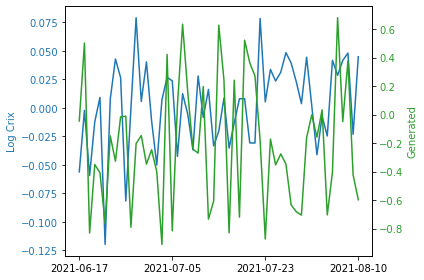

In [238]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.plot(log_crix['date'][-55:], log_crix['v'][-55:], color=color)
ax1.set_ylabel('Log Crix',color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(18))
    
ax2 = ax1.twinx()

color = 'tab:green'
ax2.plot(TS[0,:], color=color)
ax2.set_ylabel('Generated', color=color)
ax2.tick_params(axis='y', labelcolor=color)

#plt.title('Example of Generated TS vs. Real CRIX log returns')
plt.tight_layout()
plt.savefig('example_2axes.png', transparent=True)
plt.show()

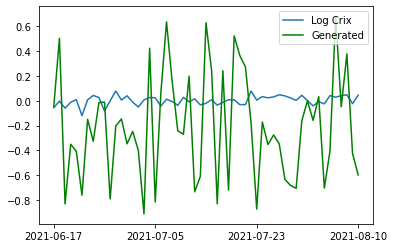

In [232]:
plt.plot(log_crix['date'][-55:], log_crix['v'][-55:], label='Log Crix')
plt.plot(TS[0,:], label='Generated', color='green')
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(18))

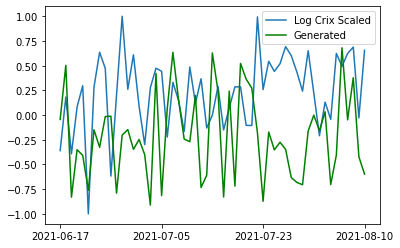

In [234]:
plt.plot(log_crix_test['date'][-55:], log_crix_test['scaled'][-55:], label='Log Crix Scaled')
plt.plot(TS[0,:], label='Generated', color='green')
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(18))
#plt.savefig('example_logscaled', transparent=True)

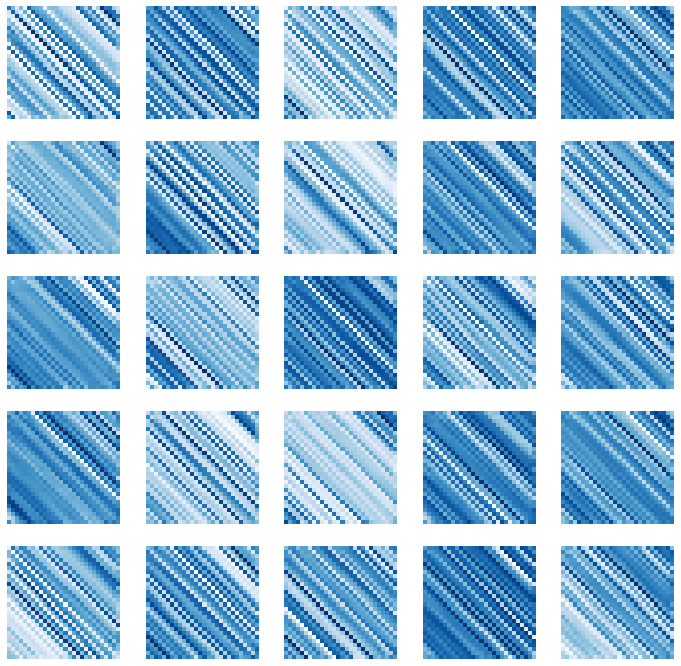

In [236]:
fig, axs = plt.subplots(r, c,figsize=(12,12))
cnt = 0
for i in range(r):
    for j in range(c):        
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='Blues')
        axs[i, j].axis('off')
        cnt += 1
#fig.savefig(f'stack_3000.png', transparent=True)

In [274]:
n = 150
latent_dim = 100
TS_g = np.zeros(shape=(n,55,))
noise = np.random.normal(0, 1, (n, latent_dim))
gen = wgan.generator.predict(noise)

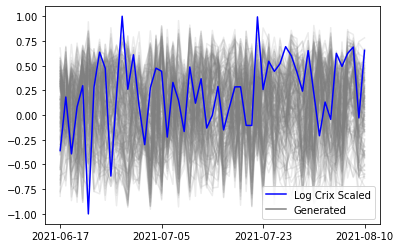

In [277]:
# compare 150 generated series to subsample of original one
for k in range(n):
    TS_g[k,:] = np.append(gen[k,27,:,0],np.flip(gen[k,:27,27,0])) 
    plt.plot(TS_g[k,:], color='gray', alpha=0.15)
plt.plot(log_crix_test['date'][-55:], log_crix_test['scaled'][-55:], label='Log Crix Scaled', color='blue')
plt.plot([],[], 'gray', label='Generated')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(18))
plt.legend(loc='lower right')
plt.savefig('logcrix_grayscale.png', transparent=True)

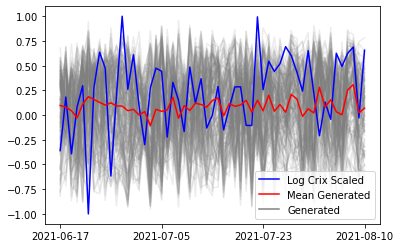

In [276]:
for i in range(55):
    TS_mean[i] = np.mean(TS_g[:,i])
    
for k in range(n):
    plt.plot(TS_g[k,:], color='gray', alpha=0.15)
plt.plot(log_crix_test['date'][-55:], log_crix_test['scaled'][-55:], label='Log Crix Scaled', color='blue')
plt.plot(TS_mean, color='red', label='Mean Generated')
plt.plot([],[], 'gray', label='Generated')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(18))
plt.legend(loc='lower right')
plt.savefig('logcrix_grayscale2.png', transparent=True)